# Programmentwurf Künstliche Intelligenz

## Thema :  Evidenztheorie und Case Based Reasoning

### Namen der Studierenden: 

(Hinweis: Es sind Namen anzugeben und keine Matrikelnummern. Matrikelnummern werden ausschließlich bei Klausuren zur Anonymisierung verwendet)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Einlesen der CSV-Datei
file_path = 'bikedata/sampled_data_001.csv'   # Einsetzen!
data = pd.read_csv(file_path, sep=";", decimal=",")

#### Etwas Analyse vorab ... gerne erweitern

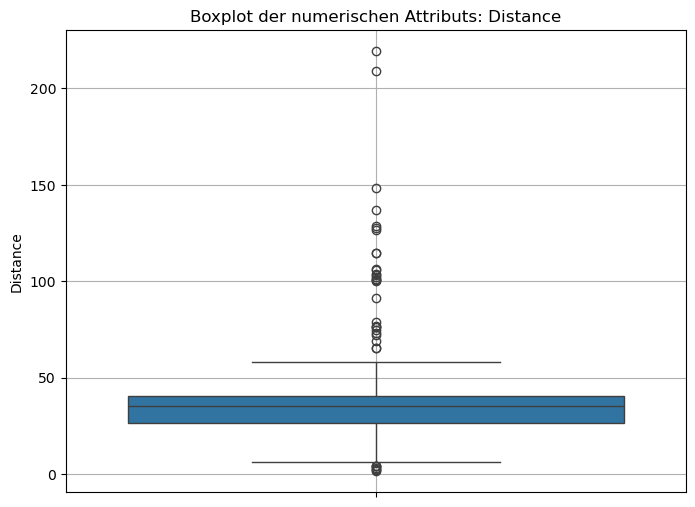

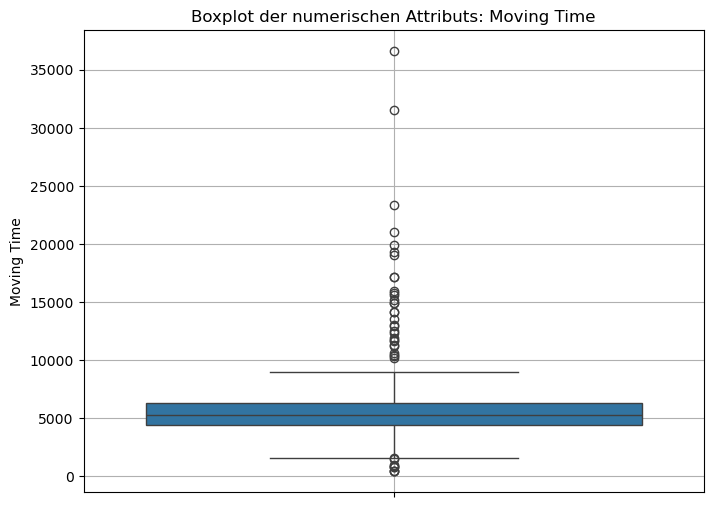

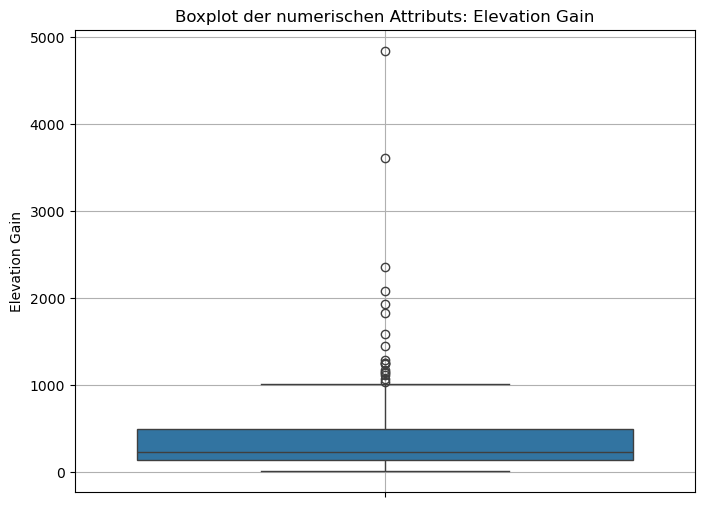

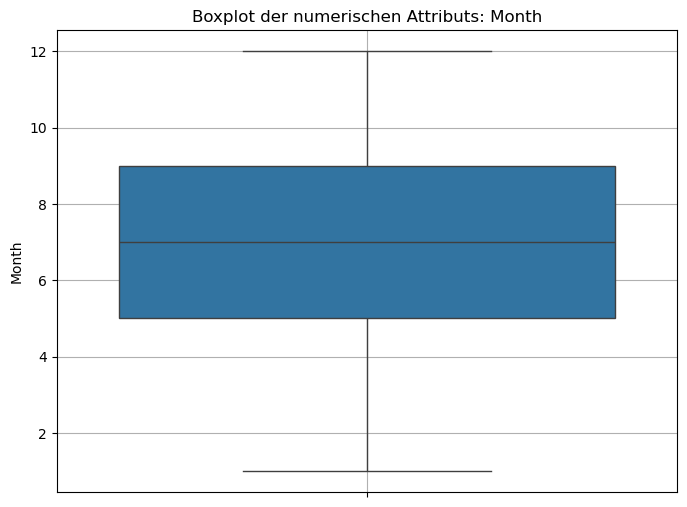

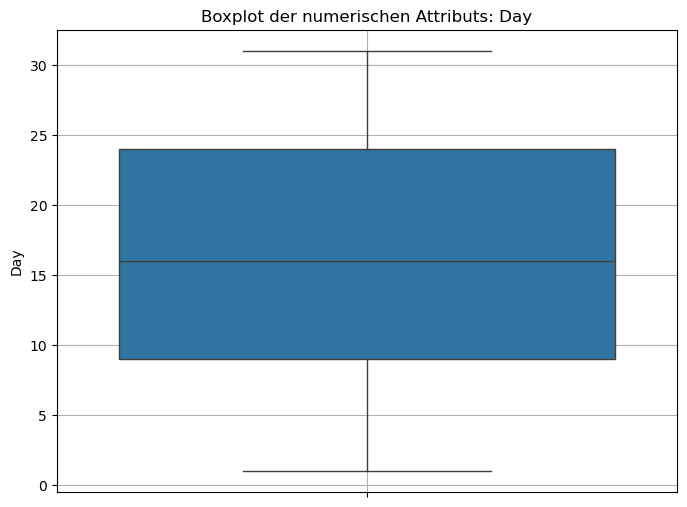

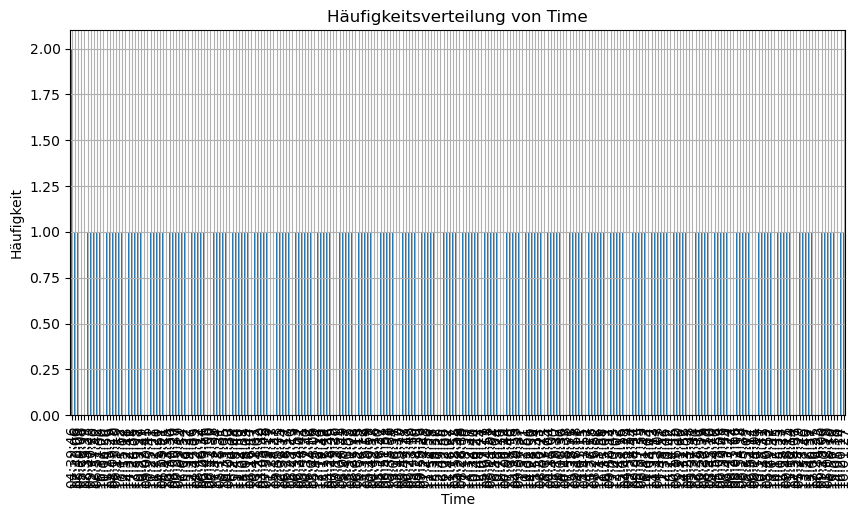

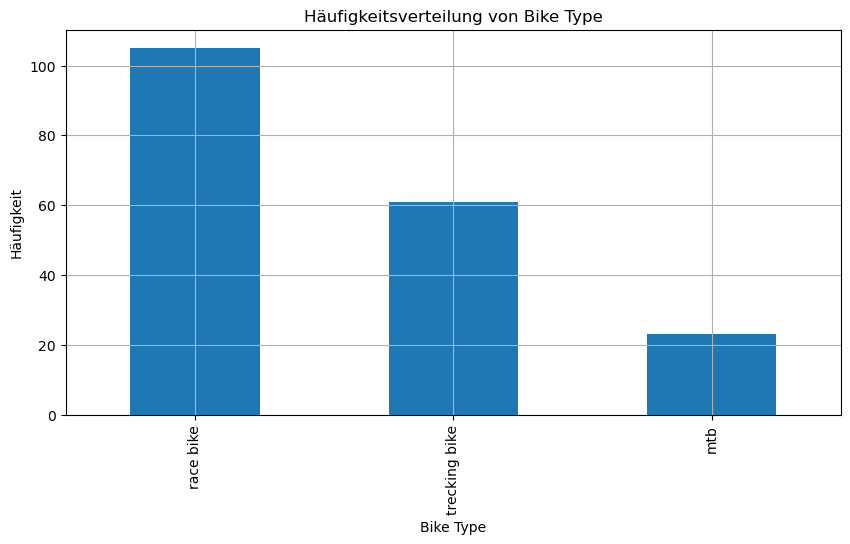

In [16]:

# Numerische Attribute - einzelne Boxplots
numeric_columns = data.select_dtypes(include='number').columns

for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot der numerischen Attributs: {column}')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

# Kategoriale Attribute - Häufigkeitsverteilungen
categorical_columns = data.select_dtypes(include='object').columns

for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    data[column].value_counts().plot(kind='bar')
    plt.title(f'Häufigkeitsverteilung von {column}')
    plt.xlabel(column)
    plt.ylabel('Häufigkeit')
    plt.grid(True)
    plt.show()


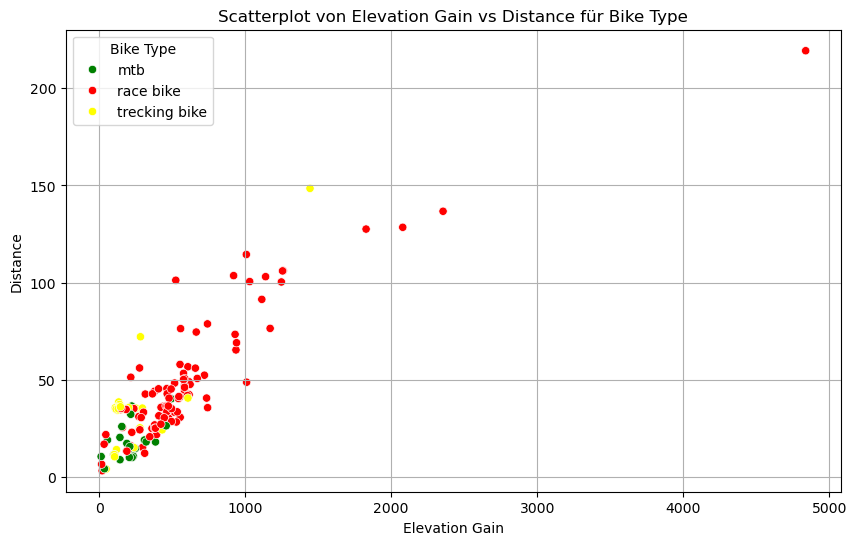

In [17]:
# Scatterplot für Elevation Gain und Distance basierend auf Bike Type

plt.figure(figsize=(10, 6))
colors = {'race bike': 'red', 'mtb': 'green', 'trecking bike': 'yellow'}
sns.scatterplot(data=data, x='Elevation Gain', y='Distance', hue='Bike Type', palette=colors)
plt.title('Scatterplot von Elevation Gain vs Distance für Bike Type')
plt.xlabel('Elevation Gain')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

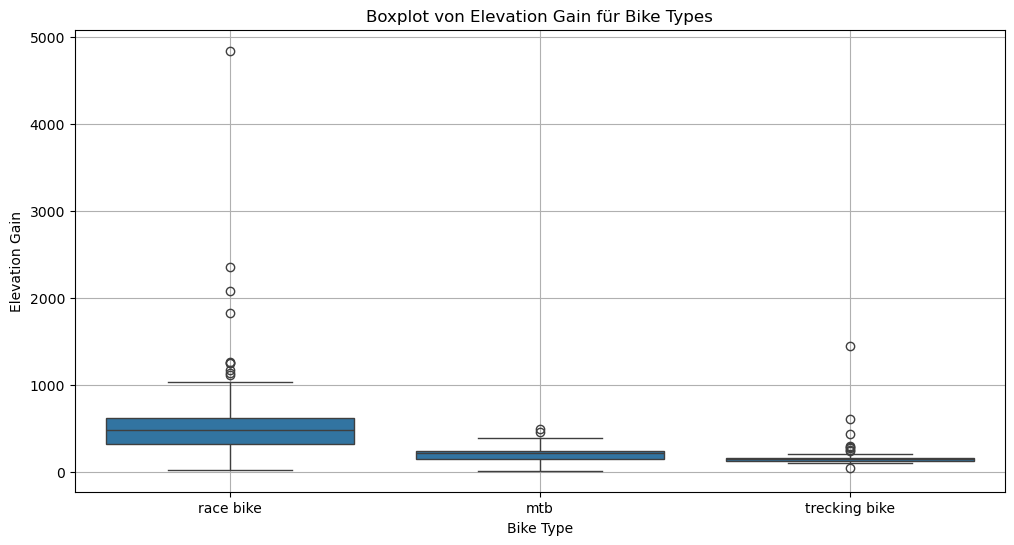

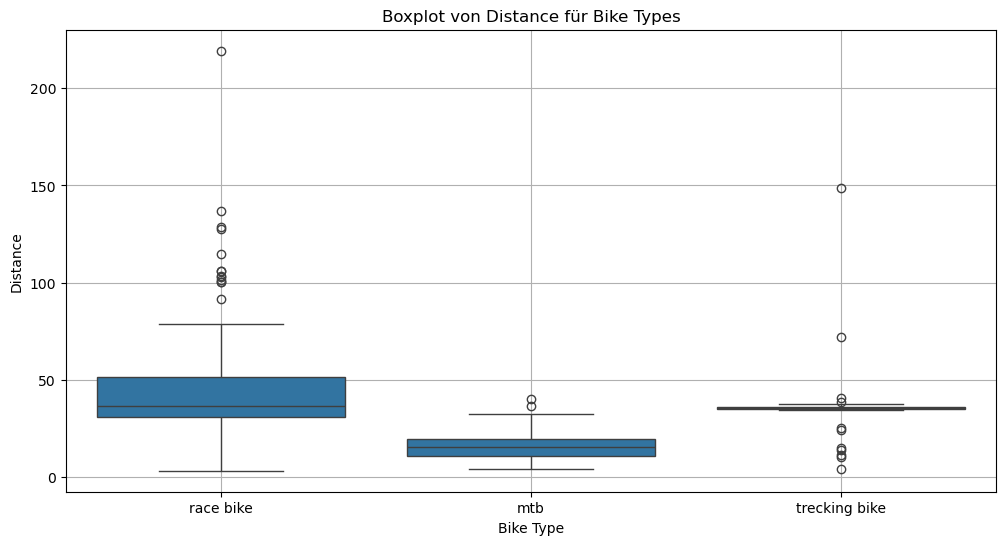

In [18]:
# Boxplots für Elevation Gain und Distance

# Boxplot für Elevation Gain
plt.figure(figsize=(12, 6))
sns.boxplot(x='Bike Type', y='Elevation Gain', data=data, order=['race bike', 'mtb', 'trecking bike'])
plt.title('Boxplot von Elevation Gain für Bike Types')
plt.xlabel('Bike Type')
plt.ylabel('Elevation Gain')
plt.grid(True)
plt.show()

# Boxplot für Distance
plt.figure(figsize=(12, 6))
sns.boxplot(x='Bike Type', y='Distance', data=data, order=['race bike', 'mtb', 'trecking bike'])
plt.title('Boxplot von Distance für Bike Types')
plt.xlabel('Bike Type')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

## Aufgabenteil 2: Evidenztheorie

Entwerfen Sie ein KI Modell auf Basis von Evidenztheorie und setzen Sie dieses als Jupyter Notebook um. Wählen Sie geeignete Fuzzy Mengen zur Bewertung und Integration der Evidenzwerte.


In [19]:
# !pip install py_dempster_shafer

from pyds import MassFunction

# Klassen (Bikes) als Einzelzeichen: r=race bike, m=mtb, t=trecking bike
CLASSES = ['r','m','t']
omega = 'rmt'  # Omega = Gesamtraum


### 1. Daten vorverarbeiten

Analog zu den Übungslaboren sollen hier Fuzzy Mengen gebildet werden. Hinweise dazu sind in der Aufgabenstellung. Diese sind ggf. noch zu erweitern und geeignet zu erfassen.

In [20]:
# (Vgl. Labor Evidenztheorie: Fuzzy-Funktionen stückweise linear um den Mittelwert ±10%)
import numpy as np

def analyze_feature(series):
    s = series.astype(float)
    mean_v = np.nanmean(s)
    min_v = np.nanmin(s)
    max_v = np.nanmax(s)
    tol = (max_v - min_v) * 0.10

    def low(x):
        if x <= mean_v:
            return (mean_v - x) / (mean_v - min_v) if mean_v > min_v else 0.0
        return 0.0

    def high(x):
        if x >= mean_v:
            return (x - mean_v) / (max_v - mean_v) if max_v > mean_v else 0.0
        return 0.0

    def medium(x):
        if (mean_v - tol) <= x <= mean_v:
            return (x - (mean_v - tol)) / tol if tol > 0 else 0.0
        elif mean_v < x <= (mean_v + tol):
            return ((mean_v + tol) - x) / tol if tol > 0 else 0.0
        return 0.0

    return low, medium, high, (min_v, mean_v, max_v, tol)

# Fuzzy-Funktionen für Distance und Elevation Gain erzeugen
dist_low, dist_med, dist_high, dist_stats = analyze_feature(data['Distance'])
elev_low, elev_med, elev_high, elev_stats = analyze_feature(data['Elevation Gain'])

# Hilfsfunktion: beste Kategorie und Zugehörigkeitsgrad
def best_category(funcs, x):
    vals = {name: max(0.0, min(1.0, f(x))) for name, f in funcs.items()}
    cat = max(vals, key=vals.get)
    return cat, vals[cat]


### Begründung zur Wahl der Fuzzy Mengen

- Ziel: Aus den kontinuierlichen Attributen `Distance` (km) und `Elevation Gain` (m) interpretierbare Evidenzen für die Klassen `race bike`, `mtb`, `trecking bike` ableiten.
- Ansatz (wie im Evidence-Lab): Stückweise lineare Fuzzy-Mengen `low / medium / high` je Merkmal. `medium` ist um den datengetriebenen Mittelwert ±10% definiert; außerhalb wachsen `low` bzw. `high` linear an.
- Rationale für die Wahl:
  - Datennah: Mittelwert und Spannweite stammen direkt aus dem Datensatz; ±10% liefert eine robuste, aber nicht zu breite Toleranzzone.
  - Interpretierbarkeit: Lineare Übergänge sind einfach zu erklären und zu visualisieren; sie vermeiden harte Schwellen.
  - Stabilität: Der Ansatz ist unempfindlich gegenüber vereinzelten Ausreißern und kann bei Bedarf (z. B. 5–15%) leicht nachjustiert werden.
- Mapping der Fuzzy-Kategorien auf Klassen (Domänenwissen):
  - `Distance`: high → `race bike` (lange Strecken), medium → `trecking bike` (Touren), low → `mtb` (kürzer).
  - `Elevation Gain`: high → `mtb` (viel HM), medium → `race bike` (profilierte Straße), low → `trecking bike` (gemäßigt).
- Evidenzableitung je Merkmal: Winner-takes-all pro Merkmal (die Kategorie mit der höchsten Zugehörigkeit) liefert den Klassenvorschlag; der zugehörige Fuzzy-Wert μ dient als Stärke der Evidenz.
- Abbildung auf Dempster–Shafer: Ein Anteil α=0.8 der Masse geht auf das jeweilige Singleton (Klasse), der Rest (1−α) auf Ω (Ignoranz).
  - Begründung: Der Ω-Anteil modelliert Unsicherheit (Überlappung der Mengen, Messrauschen) und verhindert Überkonfidenz einzelner Merkmale.
- Alternativen / Sensitivität: Trapezfunktionen (breiteres Plateau), Quantil-basierte Grenzen statt ±10%, oder Soft-Voting über alle drei Kategorien statt Winner-takes-all. Diese Optionen sind möglich und können bei Bedarf gegen die Validierungsmetriken getestet werden.


### 2. Daten mit Evidenztheorie verarbeiten

Zusammenführen der Daten durch Akkumulation (Dempsters Regel).

In [21]:
# Evidenz aus Fuzzy-Kategorien ableiten und per Dempster kombinieren (vgl. Übungsblatt)

# Mapping der Fuzzy-Kategorien auf Klassen-Buchstaben
dist_to_cls = {'low': 'm', 'medium': 't', 'high': 'r'}  # kurz→mtb, mittel→trekking, lang→race
elev_to_cls = {'low': 't', 'medium': 'r', 'high': 'm'}  # wenig→trekking, mittel→race, viel→mtb

alpha = 0.8  # Anteil für Singletons, Rest an Omega (Unsicherheit)
label_map = {'r': 'race bike', 'm': 'mtb', 't': 'trecking bike'}

preds = []
masses = []
for _, row in data.iterrows():
    try:
        d = float(row['Distance']); e = float(row['Elevation Gain'])
    except Exception:
        preds.append(None); masses.append(None); continue

    cat_d, mu_d = best_category({'low': dist_low, 'medium': dist_med, 'high': dist_high}, d)
    cat_e, mu_e = best_category({'low': elev_low, 'medium': elev_med, 'high': elev_high}, e)

    m1 = MassFunction({dist_to_cls[cat_d]: alpha * mu_d, omega: 1 - alpha * mu_d})
    m2 = MassFunction({elev_to_cls[cat_e]: alpha * mu_e, omega: 1 - alpha * mu_e})
    m3 = m1 & m2

    scores = {c: (m3[c] if c in m3 else 0.0) for c in CLASSES}
    best = max(scores, key=scores.get)
    preds.append(label_map[best])
    masses.append(m3)

data['Pred_DS'] = preds


### Begründungen

- Evidenzquellen: Wir nutzen zwei weitgehend unabhängige Merkmale (`Distance`, `Elevation Gain`) als getrennte Evidenzquellen – konsistent mit der Annahme schwacher Unabhängigkeit in Dempster–Shafer.
- Von Fuzzy zu Evidenz: Pro Merkmal wird per Winner-takes-all die stärkste Kategorie gewählt; deren Zugehörigkeit μ bildet die Vertrauensstärke der Evidenz. So entsteht je Merkmal ein einfaches Basismaß mit Singleton und Ω.
- Ω (Ignoranz): Ein Anteil 1−α (hier 0.2) geht auf Ω, um Überkonfidenz zu vermeiden und Unsicherheit (Überlappungen/Schwankungen) explizit zu modellieren.
- Dempsters Regel: Die Kombination verdichtet übereinstimmende Evidenzen und dämpft widersprüchliche durch den Konfliktterm K (Normierung über 1−K). Hoher Konflikt führt zu höherer Masse auf Ω.
- Entscheidungsregel: Auswahl der Klasse mit der höchsten Singleton-Masse. Alternativ wäre BetP (pignistische Wahrscheinlichkeit) möglich; wir bleiben beim lab-nahen, transparenten Max-Mass-Kriterium.
- Parametrik: α=0.8 (stärkerer Fokus auf die Merkmalsevidenz, dennoch Restunsicherheit). Die ±10%-Zone für `medium` kommt aus der datengetriebenen Lab-Heuristik und kann per Validierung feinjustiert werden.
- Mapping (Domänenwissen): `Distance` high→race, medium→trekking, low→mtb; `Elevation Gain` high→mtb, medium→race, low→trekking. Dies reflektiert typische Nutzungsprofile.
- Grenzen und Erweiterungen: Weitere Merkmale (z. B. `Moving Time`, Saison) könnten als zusätzliche Evidenzquellen integriert werden; Soft-Voting über alle drei Fuzzy-Kategorien (statt Winner-takes-all) reduziert Informationsverlust, erhöht aber Komplexität.


### 3. Test und Bewertung 

Wie gut ist der Klassifikator? Prüfen Sie Ihre Konfiguration und testen Sie geeignet. 

In [22]:
# Evaluation Evidenztheorie
df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')]
if len(df_eval) > 0:
    acc = (df_eval['Pred_DS'] == df_eval['Bike Type']).mean()
    print(f'Accuracy (DS): {acc:.3f}  | n={len(df_eval)}  | alpha={alpha}')
else:
    print('Keine gelabelten Daten für die Bewertung vorhanden.')


Accuracy (DS): 0.698  | n=189  | alpha=0.8


### Diskussion der Ergebnisse 

<...Ihr Text...>

## Aufgabenteil 2: Case Based Reasoning

Entwerfen Sie ein KI Modell auf Basis von Case Based Reasoning und setzen
Sie dieses als Jupyter Notebook um. Wählen Sie geeignete Vorgehensweisen um die Fallbasis
aufzubauen (CBL) und geeignete Ähnlichkeitsmaße.

### 1. Ähnlichkeitsmaß definieren

Entwerfen Sie ein zur Aufgabenstellung passendes und geeignetes Ähnlichkeitsmaß.

In [23]:
# Ähnlichkeitsmaß (vgl. Lab CBR: Cosinus-Ähnlichkeit über numerische Merkmale)
try:
    from sklearn.metrics.pairwise import cosine_similarity
    _USE_SKLEARN = True
except Exception:
    _USE_SKLEARN = False
    import math

def aehnlichkeit(person1, person2):
    """
    Berechnet die Ähnlichkeit (0..1) zwischen zwei Fahrten.
    Verwendet Distance und Elevation Gain analog zu den Lab-Beispielen.
    """
    merkmale = ['Distance', 'Elevation Gain']
    v1 = [float(person1[m]) for m in merkmale]
    v2 = [float(person2[m]) for m in merkmale]
    if _USE_SKLEARN:
        return float(cosine_similarity([v1], [v2])[0][0])
    # Fallback: manuelle Cosinus-Ähnlichkeit
    num = sum(a*b for a, b in zip(v1, v2))
    d1 = math.sqrt(sum(a*a for a in v1))
    d2 = math.sqrt(sum(b*b for b in v2))
    return (num / (d1*d2)) if (d1 > 0 and d2 > 0) else 0.0


### Begründung zur Wahl des Ähnlichkeitsmaßes

<...Ihr Text...>

### 2. CBR Zyklus umsetzen

Zunächst wird RETRIEVE benötigt. Dann sollte geprüft werden ob das Ergebnis bereits ausreicht. Wenn nicht, sollte geprüft werden, ob man die Daten in die Fallbasis aufnimmt. Die Fallbasis ist klein zu halten.

In [24]:
# Beispiel aus dem Übungslabor - durch eigene Lösung zu ersetzen

def finde_aehnlichsten_fall(df, person_zu_vergleichen):
    """
    Findet die Person im DataFrame, die die größte Ähnlichkeit zur gegebenen Person hat.

    Args:
        df: Ein Pandas DataFrame mit den Personendaten.
        person_zu_vergleichen: Ein Dictionary, das die Merkmale der Person zum Vergleich enthält.

    Returns:
        tuple: Ein Tupel mit (index, ähnlichkeit), wobei index der Index der ähnlichsten Person im DataFrame und ähnlichkeit der Ähnlichkeitswert ist.
    """

    max_aehnlichkeit = -1
    index_aehlichste_person = -1

    for i, row in df.iterrows():
        person_im_df = row.to_dict()

        a = aehnlichkeit(person_zu_vergleichen, person_im_df)

        if a > max_aehnlichkeit:
            max_aehnlichkeit = a
            index_aehlichste_person = i
            aehnlichster_datensatz = row

    return index_aehlichste_person, max_aehnlichkeit, aehnlichster_datensatz

In [25]:
# CBL umsetzen (vgl. Übungslabor): kleine Fallbasis aufbauen
import pandas as pd

gelabelt = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if len(gelabelt) == 0:
    cases = pd.DataFrame(columns=list(data.columns))
else:
    cases = gelabelt.iloc[:1].copy()  # initialer Fall
    schwelle = 0.98  # nur hinzufügen, wenn kein sehr ähnlicher Fall existiert
    for i, row in gelabelt.iloc[1:].iterrows():
        _, max_sim, _ = finde_aehnlichsten_fall(cases, row.to_dict())
        if max_sim < schwelle:
            cases = pd.concat([cases, pd.DataFrame([row])], ignore_index=True)

print(f'Fallbasis aufgebaut: {len(cases)} Fälle aus {len(gelabelt)} gelabelten Einträgen.')


Fallbasis aufgebaut: 3 Fälle aus 189 gelabelten Einträgen.


### Begründungen 

<...Ihr Text...>

### 3. Test und Bewertung

Wie gut ist der Klassifikator? Prüfen Sie Ihre Konfiguration (u.a. abhängig von Ähnlichkeitsfunktion) und testen Sie geeignet. 

In [26]:
# Bewertung CBR (vgl. Lab: Trefferquote)
def treffer(data, cases):
    korrekt = 0
    gesamt = 0
    for _, row in data.iterrows():
        if pd.isna(row['Bike Type']) or row['Bike Type'] == '':
            continue
        _, _, case = finde_aehnlichsten_fall(cases, row.to_dict())
        pred = case['Bike Type'] if 'Bike Type' in case else None
        if pred == row['Bike Type']:
            korrekt += 1
        gesamt += 1
    return korrekt, gesamt, (korrekt/gesamt if gesamt else 0.0)

korrekt, gesamt, quote = treffer(gelabelt, cases)
print(f'Trefferquote (CBR): {quote:.3f}  | korrekt={korrekt} / {gesamt}  | k=1 (nearest)')


Trefferquote (CBR): 0.376  | korrekt=71 / 189  | k=1 (nearest)


### Diskussion der Ergebnisse 

<...Ihr Text...>

# Abschluss

Vergleich der beiden Verfahren. Ggf. ist hier noch Code zum Vergleich zu ergänzen, ansonsten weitgehend durch Text.

<...Ihr Text...>